Do error analysis comparing literature-augmented models to baseline models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from collections import Counter
from itertools import product
from pathlib import Path
from scipy import stats

from os import getenv

%matplotlib inline

In [2]:
from df_utils import stratify_df, bin_ethnicity
from plotting_utils import create_multi_hist

In [3]:
INTERMEDIATE_PRODUCTS_DIR = Path("../intermediate_products/")

In [4]:

demographics_sheet = pd.read_csv(Path(getenv("MIMIC_3_DIR")) / 'demographics_sheet.csv')
baseline_results = pd.read_pickle(INTERMEDIATE_PRODUCTS_DIR / 'umlsbert_baseline_mor_results.pkl')
weightavg_results = pd.read_pickle(INTERMEDIATE_PRODUCTS_DIR / 'umlsbert_wgtavg_mor_results.pkl') 
softvote_results = pd.read_pickle(INTERMEDIATE_PRODUCTS_DIR / 'umlsbert_softvote_mor_results.pkl')

In [5]:
merged_results = pd.merge(baseline_results, softvote_results, on='HADM_ID', how='inner')
merged_results['HADM_ID'] = merged_results['HADM_ID'].map(int)
merged = pd.merge(merged_results, demographics_sheet, on='HADM_ID', how='inner')
merged = merged.drop(["true_labels_y"], axis=1)
merged = merged.rename({"true_labels_x": "MOR"}, axis=1)
merged["pred_delta"] = merged['pred_probs_y'] - merged['pred_probs_x']
merged["squared_err_x"] = (merged['MOR'] - merged['pred_probs_x'])**2
merged["squared_err_y"] = (merged['MOR'] - merged['pred_probs_y'])**2
merged["squared_err_delta"] = merged['squared_err_y'] - merged['squared_err_x']
merged["squared_err_pct_change"] = (merged['squared_err_y'] - merged['squared_err_x']) / merged['squared_err_x']
merged = merged[merged['AGE'] >= 18]
merged['ETHNICITY_BINNED'] = merged['ETHNICITY'].apply(bin_ethnicity)
print(merged.shape)
print(merged.columns)

(9788, 16)
Index(['HADM_ID', 'MOR', 'pred_probs_x', 'pred_probs_y', 'SUBJECT_ID', 'AGE',
       'GENDER', 'ETHNICITY', 'LANGUAGE', 'INSURANCE', 'pred_delta',
       'squared_err_x', 'squared_err_y', 'squared_err_delta',
       'squared_err_pct_change', 'ETHNICITY_BINNED'],
      dtype='object')


In [6]:
merged_relevant = merged[(merged['MOR'] == 1) | (merged['pred_probs_x'] > 0.2) | (merged['pred_probs_y'] > 0.2)]
outcome_stratified = stratify_df(merged_relevant, 'MOR')

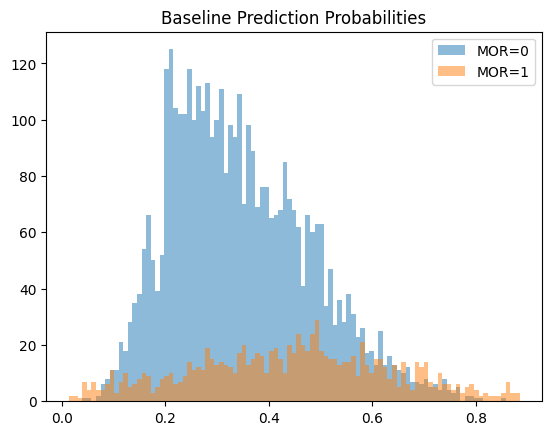

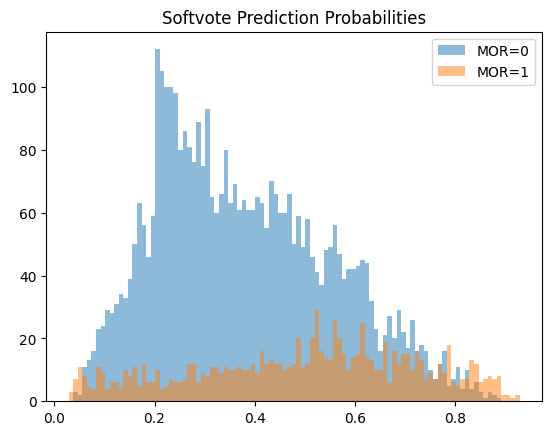

In [7]:
create_multi_hist([df['pred_probs_x'] for df in outcome_stratified.values()], outcome_stratified.keys(), title="Baseline Prediction Probabilities", show=True)
create_multi_hist([df['pred_probs_y'] for df in outcome_stratified.values()], outcome_stratified.keys(), title="Softvote Prediction Probabilities")

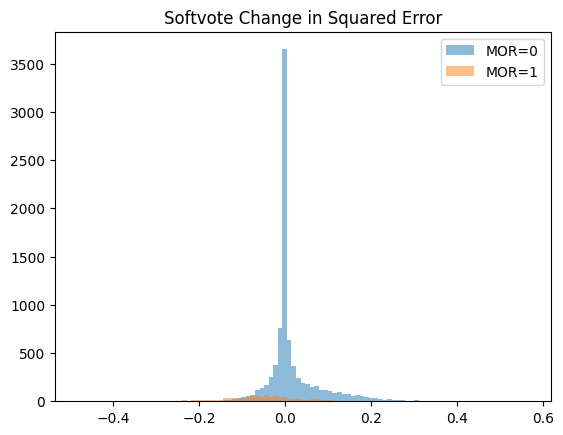

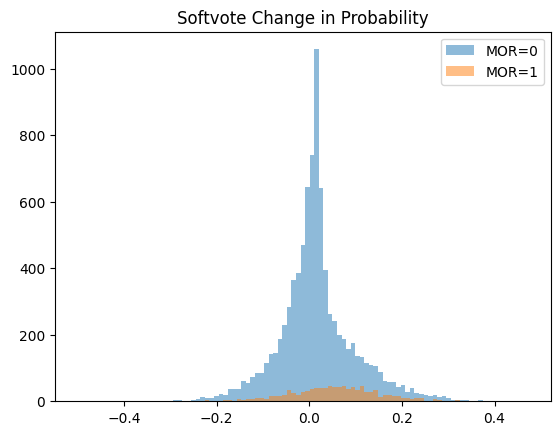

In [146]:
create_multi_hist([df['squared_err_delta'] for df in outcome_stratified.values()], outcome_stratified.keys(), title="Softvote Change in Squared Error", show=True)
create_multi_hist([df['pred_delta'] for df in outcome_stratified.values()], outcome_stratified.keys(), title="Softvote Change in Probability", show=True)


In [151]:
print(merged[(merged["GENDER"]=='F') & (merged["squared_err_delta"] > 0)].shape)
print(merged[(merged["GENDER"]=='M') & (merged["squared_err_delta"] > 0)].shape)
print(merged[(merged["GENDER"]=='F') & (merged["squared_err_delta"] <= 0)].shape)
print(merged[(merged["GENDER"]=='M') & (merged["squared_err_delta"] <= 0)].shape)


(2431, 16)
(3127, 16)
(1896, 16)
(2334, 16)


In [152]:
print(2443/(2443+1897))
print(3143/(3143+2339))

0.5629032258064516
0.5733309011309741


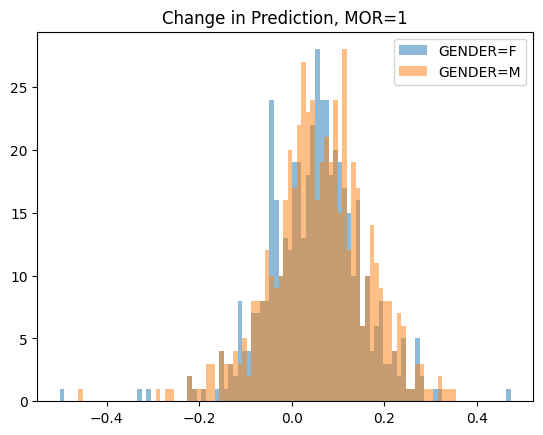

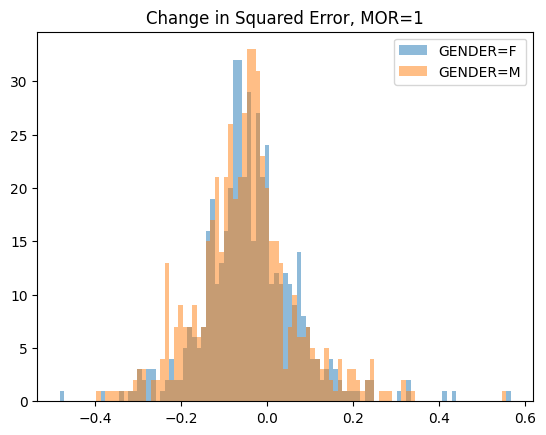

In [12]:
genderf_mor_1 = merged[(merged["GENDER"]=='F') & (merged['MOR'] == 1)]
genderm_mor_1 = merged[(merged["GENDER"]=='M') & (merged['MOR'] == 1)]
create_multi_hist([genderf_mor_1['pred_delta'], genderm_mor_1['pred_delta']], ["GENDER=F", "GENDER=M"], title="Change in Prediction, MOR=1", show=True)
create_multi_hist([genderf_mor_1['squared_err_delta'], genderm_mor_1['squared_err_delta']], ["GENDER=F", "GENDER=M"], title="Change in Squared Error, MOR=1")

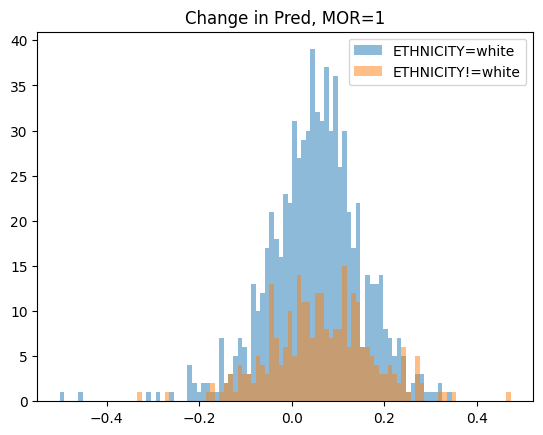

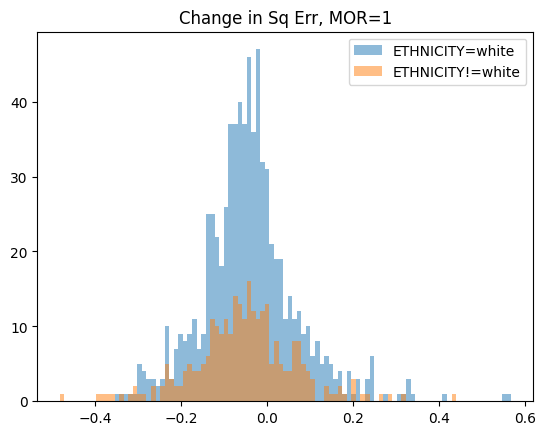

In [13]:
binned_ethnicities = merged.copy()
binned_ethnicities["ETHNICITY"] = merged["ETHNICITY"].apply(bin_ethnicity)
ethnicity_stratified = stratify_df(binned_ethnicities[binned_ethnicities['MOR'] == 1], 'ETHNICITY')
otherizing = []
for k,v in ethnicity_stratified.items():
    if k != 'ETHNICITY=white':
        otherizing.append(v)
otherizing = pd.concat(otherizing)
create_multi_hist([ethnicity_stratified['ETHNICITY=white']['pred_delta'], otherizing['pred_delta']], ['ETHNICITY=white', 'ETHNICITY!=white'], title="Change in Pred, MOR=1", show=True)
create_multi_hist([ethnicity_stratified['ETHNICITY=white']['squared_err_delta'], otherizing['squared_err_delta']], ['ETHNICITY=white', 'ETHNICITY!=white'], title="Change in Sq Err, MOR=1", show=True)

In [14]:
ethnicity_stratified = stratify_df(binned_ethnicities[binned_ethnicities['MOR'] == 1], 'ETHNICITY')
for k,v in ethnicity_stratified.items():
    print(k)
    print(f"\tN={v.shape[0]}")
    print("\tChange in Pred Prob:")
    print(f"\tmean: {np.mean(v['pred_delta'])}, st. dev.: {np.std(v['pred_delta'])}")
    print("\tChange in Squared error:")
    print(f"\tmean: {np.mean(v['squared_err_delta'])}, st. dev.: {np.std(v['squared_err_delta'])}")

ETHNICITY=white
	N=748
	Change in Pred Prob:
	mean: 0.05139396193980135, st. dev.: 0.10076776896114371
	Change in Squared error:
	mean: -0.04232410020033841, st. dev.: 0.11138044806639416
ETHNICITY=other
	N=20
	Change in Pred Prob:
	mean: 0.033149074763059616, st. dev.: 0.08332091684921923
	Change in Squared error:
	mean: -0.022280489670783367, st. dev.: 0.07946167716279405
ETHNICITY=hispanic
	N=24
	Change in Pred Prob:
	mean: 0.09990345283101003, st. dev.: 0.09357241909849023
	Change in Squared error:
	mean: -0.09620518741651113, st. dev.: 0.0997707104417851
ETHNICITY=asian
	N=19
	Change in Pred Prob:
	mean: 0.07111902613388865, st. dev.: 0.09825136261965393
	Change in Squared error:
	mean: -0.060179070449279726, st. dev.: 0.11835135241075743
ETHNICITY=declined
	N=8
	Change in Pred Prob:
	mean: 0.07430163770914078, st. dev.: 0.10629473403139902
	Change in Squared error:
	mean: -0.06151520122784371, st. dev.: 0.13057189512571885
ETHNICITY=black
	N=86
	Change in Pred Prob:
	mean: 0.0746

In [15]:
gender_stratified = stratify_df(merged[merged['MOR'] == 1], 'GENDER')
for k,v in gender_stratified.items():
    print(k)
    print(f"\tN={v.shape[0]}")
    print("\tChange in Pred Prob:")
    print(f"\tmean: {np.mean(v['pred_delta'])}, st. dev.: {np.std(v['pred_delta'])}")
    print("\tChange in Squared error:")
    print(f"\tmean: {np.mean(v['squared_err_delta'])}, st. dev.: {np.std(v['squared_err_delta'])}")

GENDER=F
	N=484
	Change in Pred Prob:
	mean: 0.04945902040705454, st. dev.: 0.1002961196605242
	Change in Squared error:
	mean: -0.04028763877116004, st. dev.: 0.11063166865072323
GENDER=M
	N=541
	Change in Pred Prob:
	mean: 0.059455680641967136, st. dev.: 0.10581763487889566
	Change in Squared error:
	mean: -0.05024589132456354, st. dev.: 0.11687636469447317


In [16]:
insurance_stratified = stratify_df(merged[merged['MOR'] == 1], 'INSURANCE')
for k,v in insurance_stratified.items():
    print(k)
    print(f"\tN={v.shape[0]}")
    print("\tChange in Pred Prob:")
    print(f"\tmean: {np.mean(v['pred_delta'])}, st. dev.: {np.std(v['pred_delta'])}")
    print("\tChange in Squared error:")
    print(f"\tmean: {np.mean(v['squared_err_delta'])}, st. dev.: {np.std(v['squared_err_delta'])}")

INSURANCE=Government
	N=21
	Change in Pred Prob:
	mean: 0.04841163062623569, st. dev.: 0.08968952902851396
	Change in Squared error:
	mean: -0.05603311224423276, st. dev.: 0.1124228479468541
INSURANCE=Medicare
	N=720
	Change in Pred Prob:
	mean: 0.05059165261530628, st. dev.: 0.09673068317631094
	Change in Squared error:
	mean: -0.03927236157820138, st. dev.: 0.10464000611507031
INSURANCE=Self Pay
	N=13
	Change in Pred Prob:
	mean: 0.037922728090332106, st. dev.: 0.0833282333021059
	Change in Squared error:
	mean: -0.03427941011669952, st. dev.: 0.09041534855043137
INSURANCE=Medicaid
	N=57
	Change in Pred Prob:
	mean: 0.09757459206147152, st. dev.: 0.11023215980289165
	Change in Squared error:
	mean: -0.08760929902328227, st. dev.: 0.12556513133233307
INSURANCE=Private
	N=214
	Change in Pred Prob:
	mean: 0.058907980212471754, st. dev.: 0.12109471033368666
	Change in Squared error:
	mean: -0.05509386122687976, st. dev.: 0.13727291455879384


In [17]:
arr = np.zeros([2,8], dtype=int)
counts_dict = binned_ethnicities.value_counts(['ETHNICITY', 'GENDER']).to_dict()
print(counts_dict)
ethnicities = list(set([count_key[0] for count_key in counts_dict.keys()]))
genders = list(set([count_key[1] for count_key in counts_dict.keys()]))
for demographics, count in counts_dict.items():
    ethnicity, gender = demographics
    arr[genders.index(gender), ethnicities.index(ethnicity)] = count
print(arr)



{('white', 'M'): 4001, ('white', 'F'): 3018, ('black', 'F'): 621, ('unknown', 'M'): 518, ('black', 'M'): 428, ('unknown', 'F'): 330, ('hispanic', 'M'): 187, ('other', 'M'): 162, ('hispanic', 'F'): 139, ('asian', 'M'): 118, ('asian', 'F'): 100, ('other', 'F'): 94, ('declined', 'M'): 68, ('declined', 'F'): 36, ('native', 'F'): 2}
[[3018   94    2  139  100   36  621  330]
 [4001  162    0  187  118   68  428  518]]


Text(0.5, 1.0, 'Change in squared error by ethnicity, MOR=1')

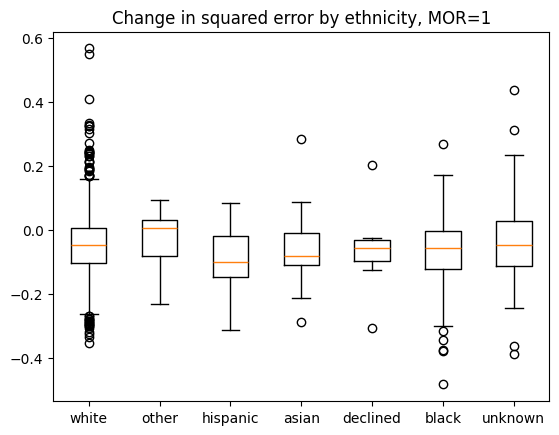

In [18]:
fig, ax = plt.subplots()
ax.boxplot([sub_df['squared_err_delta'] for sub_df in ethnicity_stratified.values()])
ax.set_xticklabels([k.strip('ETHNICITY=') for k in ethnicity_stratified.keys()])
ax.set_title("Change in squared error by ethnicity, MOR=1")

Text(0.5, 1.0, 'Change in squared error by Insurance Type, MOR=1')

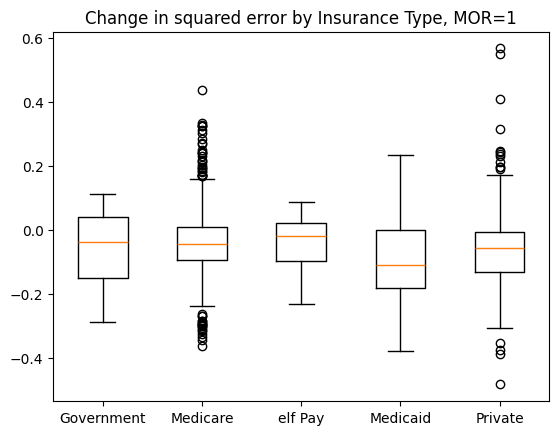

In [19]:
fig, ax = plt.subplots()
ax.boxplot([sub_df['squared_err_delta'] for sub_df in insurance_stratified.values()])
ax.set_xticklabels([k.strip('INSURANCE=') for k in insurance_stratified.keys()])
ax.set_title("Change in squared error by Insurance Type, MOR=1")

Text(0.5, 1.0, 'Change in squared error by GENDER, MOR=1')

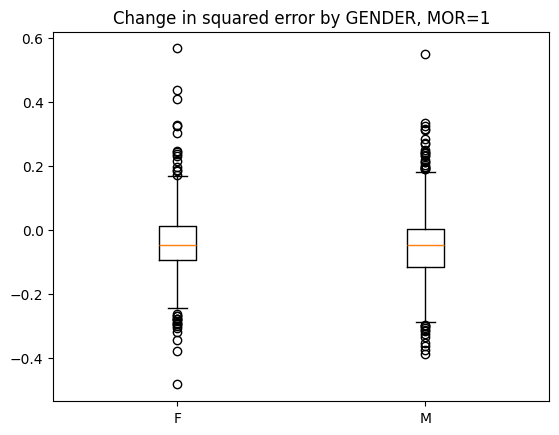

In [20]:
fig, ax = plt.subplots()
ax.boxplot([sub_df['squared_err_delta'] for sub_df in gender_stratified.values()])
ax.set_xticklabels([k.strip('GENDER=') for k in gender_stratified.keys()])
ax.set_title("Change in squared error by GENDER, MOR=1")

In [23]:
# want to 1-hot encode our demographics, then run a regression on them
# relevant = merged[(40 < merged['AGE']) & (merged['AGE'] <= 60)]
# relevant = merged_relevant
relevant = merged[merged['MOR'] == 0]
insurance_dummies = pd.get_dummies(relevant['INSURANCE']).astype(int)
eth_dummies = pd.get_dummies(relevant['ETHNICITY_BINNED']).astype(int)
gender_dummies = pd.get_dummies(relevant['GENDER'])
# all_dep = pd.concat([insurance_dummies, eth_dummies, gender_dummies], axis=1)
# 0 if male, 1 if female
gend_input = relevant['GENDER'].map(lambda gender: int(gender == 'M'))
# 0 if white, 1 if not
eth_binary_dummy = relevant['ETHNICITY_BINNED'].map(lambda eth: int(eth == 'white'))
gend_eth_interact = gend_input * eth_binary_dummy
gend_eth_interact.name = "GEND*ETH"
all_dep = pd.concat([gend_input], axis=1)
estimator = sm.OLS(relevant['squared_err_delta'], all_dep)
estimated = estimator.fit()
print(estimated.summary())

                                 OLS Regression Results                                
Dep. Variable:      squared_err_delta   R-squared (uncentered):                   0.031
Model:                            OLS   Adj. R-squared (uncentered):              0.031
Method:                 Least Squares   F-statistic:                              284.5
Date:                Tue, 09 Jan 2024   Prob (F-statistic):                    7.72e-63
Time:                        16:11:56   Log-Likelihood:                          11522.
No. Observations:                8764   AIC:                                 -2.304e+04
Df Residuals:                    8763   BIC:                                 -2.303e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [61]:
print(merged.value_counts(['MOR', 'GENDER']))
print(binned_ethnicities.groupby('MOR').value_counts(['ETHNICITY']))
print(merged.groupby('MOR').value_counts(['INSURANCE']))

MOR  GENDER
0    M         4941
     F         3856
1    M          541
     F          484
Name: count, dtype: int64
MOR  ETHNICITY
0    white        6271
     black         963
     unknown       728
     hispanic      302
     other         236
     asian         199
     declined       96
     native          2
1    white         748
     unknown       120
     black          86
     hispanic       24
     other          20
     asian          19
     declined        8
Name: count, dtype: int64
MOR  INSURANCE 
0    Medicare      4813
     Private       2862
     Medicaid       779
     Government     273
     Self Pay        70
1    Medicare       720
     Private        214
     Medicaid        57
     Government      21
     Self Pay        13
Name: count, dtype: int64


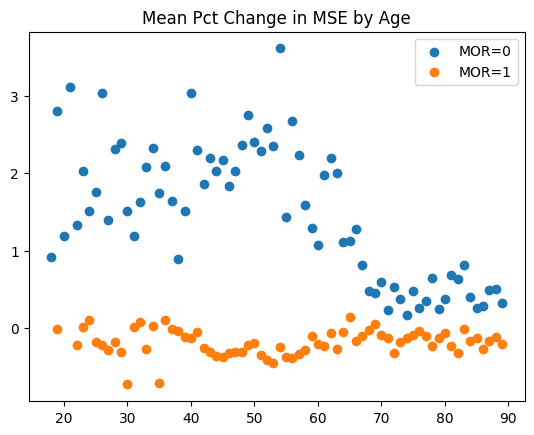

In [217]:
relevant = merged[merged['MOR'] == 0]
# relevant = merged
ages = list(range(18,90))
ages_to_plot = []
means = []
for age in ages:
    filtered = relevant[relevant['AGE'] == age]
    if filtered.shape[0]:
        ages_to_plot.append(age)
        means.append(np.mean(filtered['squared_err_pct_change']))
plt.scatter(ages_to_plot, means)
ages_to_plot = []
means = []
relevant = merged[merged['MOR'] == 1]
for age in ages:
    filtered = relevant[relevant['AGE'] == age]
    if filtered.shape[0]:
        ages_to_plot.append(age)
        means.append(np.mean(filtered['squared_err_pct_change']))
plt.scatter(ages_to_plot, means)
plt.legend(['MOR=0', 'MOR=1'])
plt.title("Mean Pct Change in MSE by Age")
plt.savefig("/Users/chaiken/research/repos/BEEPD/image_outputs/age_analysis/sq_err_pct_change_by_age.png")
# plt.scatter(relevant['AGE'], relevant['squared_err_delta'])

Text(0, 0.5, 'Mortality Proportion')

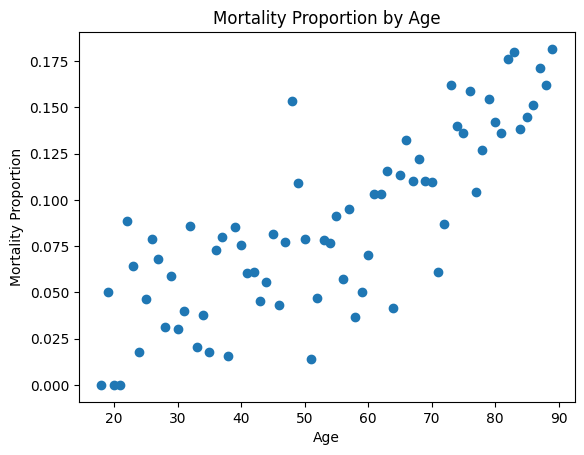

In [138]:
ages_to_plot = []
mor_proportions = []
mor = merged[merged['MOR'] == 1]
for age in ages:
    mor[mor['AGE'] == age].value_counts('MOR').get(1, 0)
    ages_to_plot.append(age)
    mor_proportions.append(mor[mor['AGE'] == age].value_counts('MOR').get(1, 0) / merged[merged['AGE'] == age].shape[0])
plt.scatter(ages_to_plot, mor_proportions)
plt.title("Mortality Proportion by Age")
plt.xlabel("Age")
plt.ylabel("Mortality Proportion")

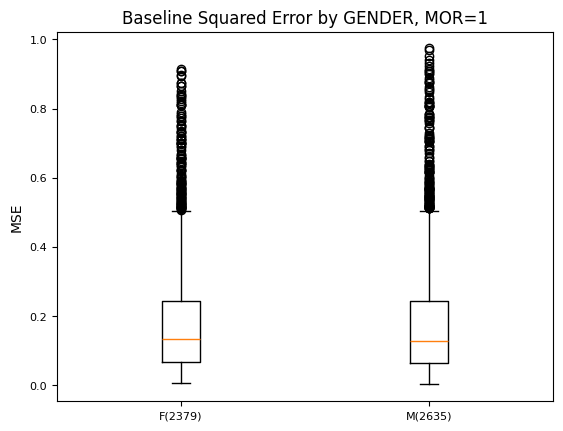

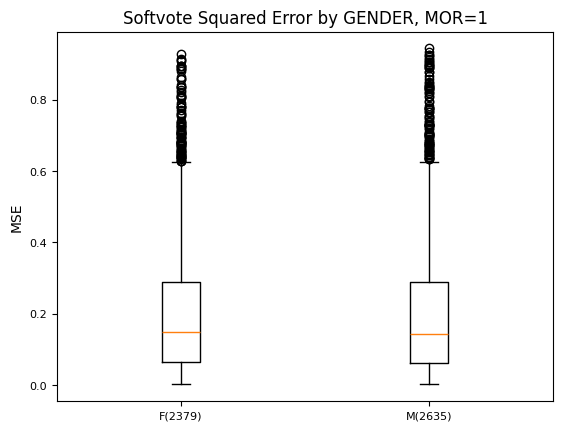

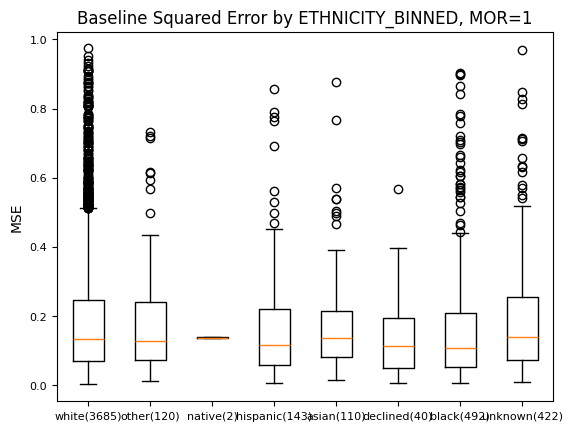

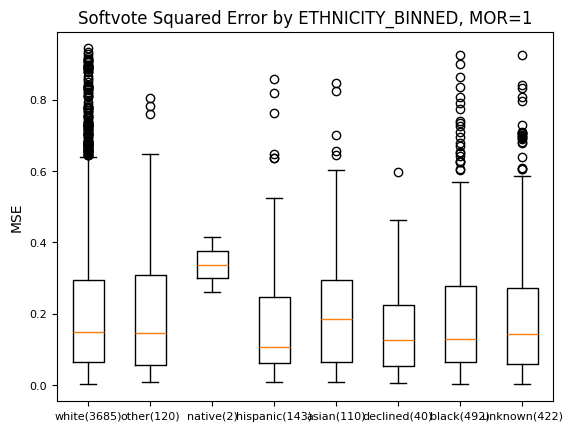

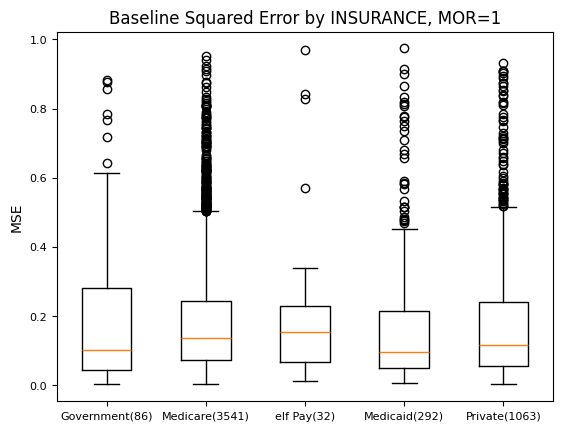

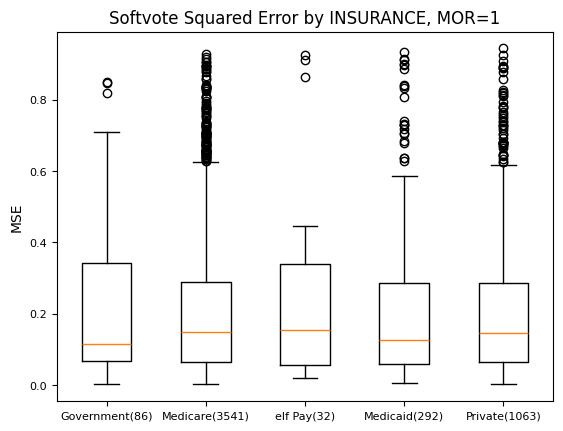

In [153]:
# Get the absolute MSE for different groups for different methods
# relevant = merged[merged['MOR'] == 1]
relevant = merged_relevant
demog_cols = ['GENDER', 'ETHNICITY_BINNED', 'INSURANCE']
outcome_cols = {
    "squared_err_x": 'Baseline',
    'squared_err_y': 'Softvote',
}
for demog_col, outcome_col in product(demog_cols, outcome_cols):
    fig, ax = plt.subplots()
    insurance_stratified = stratify_df(relevant, demog_col)
    ax.boxplot([sub_df[outcome_col] for sub_df in insurance_stratified.values()])
    ax.set_xticklabels([f"{k.strip(f'{demog_col}=')}({insurance_stratified[k].shape[0]})" for k in insurance_stratified.keys()])
    ax.set_ylabel("MSE")
    ax.tick_params(labelsize=8)
    ax.set_title(f"{outcome_cols[outcome_col]} Squared Error by {demog_col}, MOR=1")
    # plt.savefig(f"/Users/chaiken/research/repos/BEEPD/image_outputs/absolute_sq_err/sq_err_boxplot_{demog_col}_{outcome_cols[outcome_col]}.png")
    # plt.close()

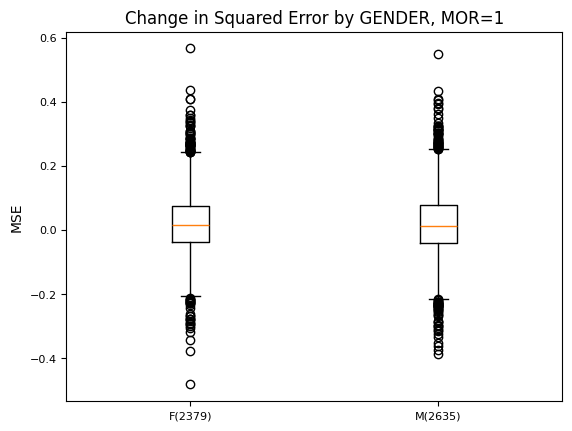

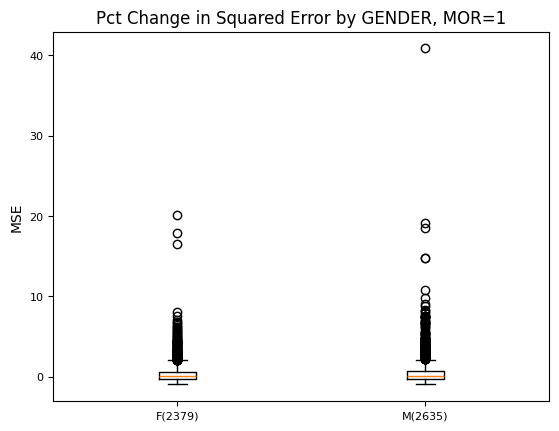

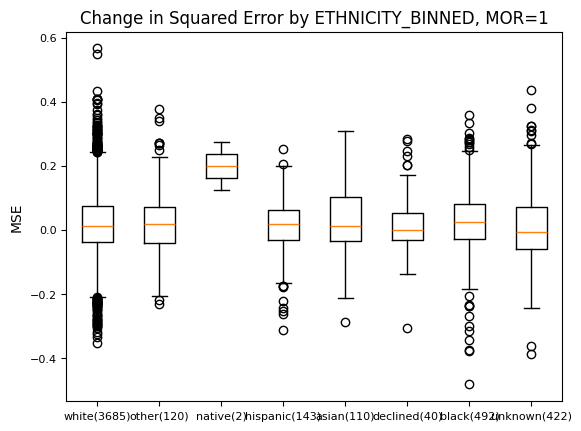

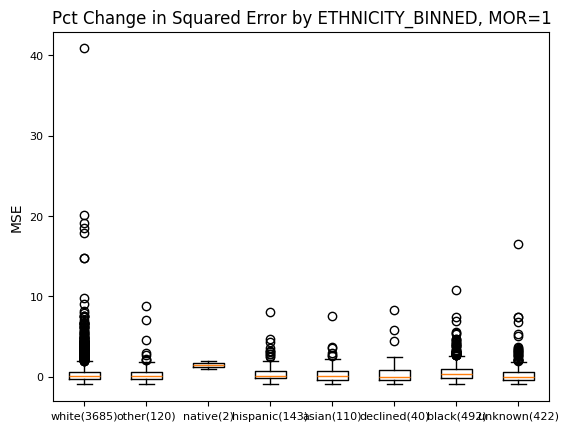

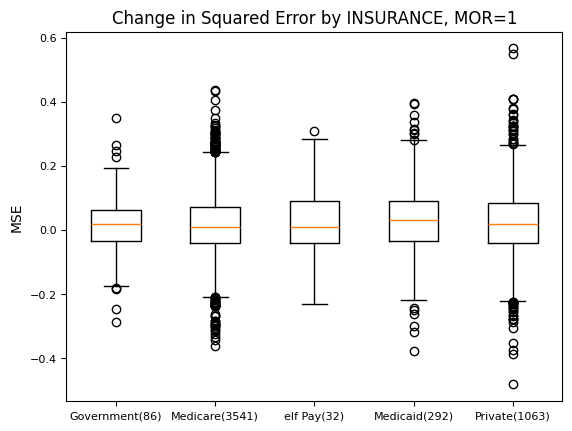

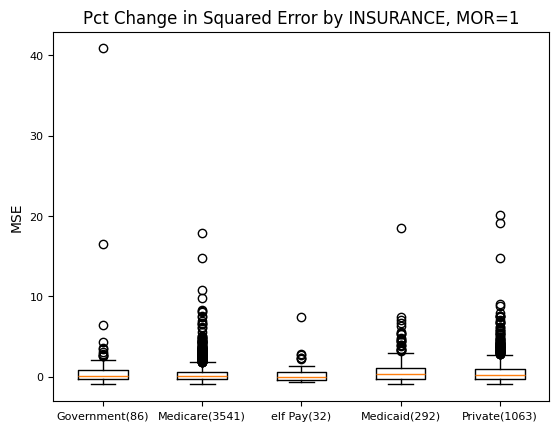

In [154]:
# Get the absolute MSE for different groups for different methods
# relevant = merged[merged['MOR'] == 1]
relevant = merged_relevant
demog_cols = ['GENDER', 'ETHNICITY_BINNED', 'INSURANCE']
outcome_cols = {
    "squared_err_delta": 'Change in',
    'squared_err_pct_change': 'Pct Change in',
}
for demog_col, outcome_col in product(demog_cols, outcome_cols):
    fig, ax = plt.subplots()
    insurance_stratified = stratify_df(relevant, demog_col)
    ax.boxplot([sub_df[outcome_col] for sub_df in insurance_stratified.values()])
    ax.set_xticklabels([f"{k.strip(f'{demog_col}=')}({insurance_stratified[k].shape[0]})" for k in insurance_stratified.keys()])
    ax.set_ylabel("MSE")
    ax.tick_params(labelsize=8)
    ax.set_title(f"{outcome_cols[outcome_col]} Squared Error by {demog_col}, MOR=1")
    # plt.savefig(f"/Users/chaiken/research/repos/BEEPD/image_outputs/relative_sq_err/sq_err_boxplot_{demog_col}_{outcome_cols[outcome_col]}.png")
    # plt.close()